In [1]:
from skimage import io,filters, morphology, measure, draw,exposure
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
from matplotlib import cm
from skimage.filters import threshold_multiotsu
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from tqdm import tqdm
from ome_types import from_tiff
import matplotlib

In [2]:
PATH = '<PATH/TO/DIR/>WAVE/Single_molecule_tracking/'

In [3]:
def f_x(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [4]:
# calculate MSD per nx delta t
def calculate_msd_under_n_deltaT(table,n):
    msd = []
    dt= 0
    for i in range(0,table.Frame.max()-n,n):
        back = table[table['Frame']==table.Frame.min()+i]
        forward = table[table['Frame']==table.Frame.min()+i+n]
        if len(back)!=0 and len(forward)!=0:
            dt = forward['T'].iloc[0]-back['T'].iloc[0]
            #Xs and Ys are half because the pixel size in the configuration file for the 100x object on the scope used is off by 2-fold. 
            msd.append(np.power(forward.X.iloc[0]*0.5-back.X.iloc[0]*0.5,2)+np.power(forward.Y.iloc[0]*0.5-back.Y.iloc[0]*0.5,2))
    return np.mean(msd),dt

In [5]:
def compute_2D_diffussion_coefficient(table):
    k = []
    for ID in np.unique(table['Track ID']):
        cur = table[table['Track ID']==ID]
        cur = cur.sort_values(by = ['T'],ascending=True)
        if len(cur)>=8:
            msd_1,dt_1 = calculate_msd_under_n_deltaT(cur,1)
            msd_2,dt_2 = calculate_msd_under_n_deltaT(cur,2)
            msd_3,dt_3 = calculate_msd_under_n_deltaT(cur,3)           
            msd_4,dt_4 = calculate_msd_under_n_deltaT(cur,4)
            if dt_4 != 0 and dt_3 != 0 and dt_2 !=0 and dt_1 !=0:
                popt, pcov = curve_fit(f_x, [dt_1,dt_2,dt_3,dt_4],[msd_1,msd_2,msd_3,msd_4]) 
                k.append(popt[0]/4)
    return k

# Compute diffussion coefficient

In [6]:
# Load tracking info csv files generated from Fiji TrackMate
path = PATH + 'Halo-sra1/spots_info/'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(path+"/"+csv_file,index_col=1,skiprows=[0,1,3])
    dataframes.append(df)
Sra1 = dataframes

In [7]:
# Load tracking info csv files generated from Fiji TrackMate
path = PATH + 'Controls/spots_info/'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(path+"/"+csv_file,index_col=1,skiprows=[0,1,3])
    dataframes.append(df)
CAAX = dataframes

In [10]:
k_sra1 = []
for sra in tqdm(Sra1):
    k_sra1.append(compute_2D_diffussion_coefficient(sra))
         


  0%|                                                    | 0/12 [00:00<?, ?it/s]/Users/muziyue/.pyenv/versions/3.8.16/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/muziyue/.pyenv/versions/3.8.16/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 12/12 [04:41<00:00, 23.43s/it]


In [12]:
ave_sra1 = []
for k in k_sra1:
    ave_sra1.append(np.mean(k))

In [13]:
with open(PATH + 'Halo-sra1/csv_data/diffusion_coefficient_sra1.csv', 'w') as f:
    for line in k_sra1:
        f.write(f"{line}\n")

In [14]:
with open(PATH + 'Halo-sra1/csv_data/diffusion_coefficient_sra1_ave.csv', 'w') as f:
    for line in ave_sra1:
        f.write(f"{line}\n")

In [15]:
k_caax = []
for caax in tqdm(CAAX):
    k_caax.append(compute_2D_diffussion_coefficient(caax))

100%|███████████████████████████████████████████| 24/24 [06:10<00:00, 15.44s/it]


In [19]:
ave_caax = []
for k in k_caax:
    ave_caax.append(np.mean(k))

In [20]:
with open(PATH + 'Controls/csv_data/diffusion_coefficient_caax_ave.csv', 'w') as f:
    for line in ave_caax:
        f.write(f"{line}\n")

In [21]:
with open(PATH + 'Controls/csv_data/diffusion_coefficient_caax.csv', 'w') as f:
    for line in k_caax:
        f.write(f"{line}\n")

# Generate plot

In [22]:
diffusion_Sra1 = pd.DataFrame()
diffusion_CAAX = pd.DataFrame()

In [23]:
diffusion_CAAX= pd.read_csv(PATH + 'Controls/csv_data/diffusion_coefficient_caax_ave.csv',names = ['CAAX'])
diffusion_Sra1= pd.read_csv(PATH + 'Halo-sra1/csv_data/diffusion_coefficient_sra1_ave.csv',names= ['Sra1'])

In [24]:
result = diffusion_Sra1
result = result.append(diffusion_CAAX)

/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_65996/2454992156.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(diffusion_CAAX)


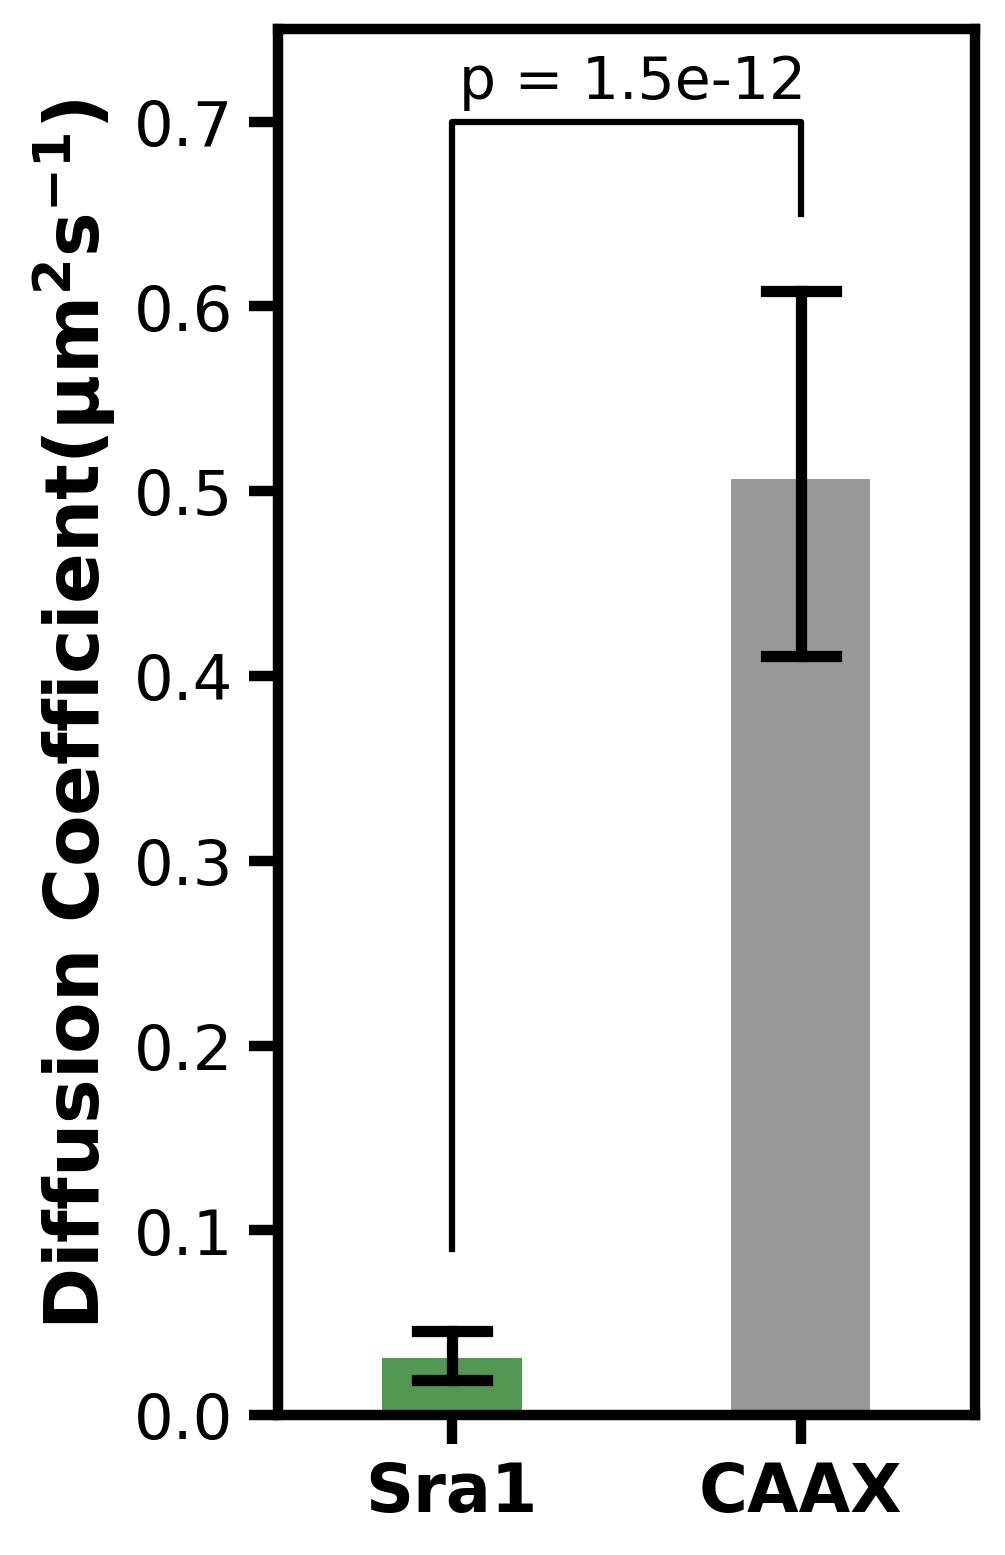

In [25]:
fig,ax = plt.subplots(figsize=(3,6),dpi = 300)
sns.barplot(result,width = 0.4,errorbar=('ci', 100),errcolor = 'black', capsize = 0.2,palette = ['#48a446','#999999'])

plt.xlim(-0.5,1.5)
plt.ylim(0,0.75)
plt.tick_params('x',labelsize = 16)
fig.text(-0.15, 0.5, r'Diffusion Coefficient($\mathbf{µm^{2}s^{-1}}$)', va='center', rotation='vertical',size = 18, fontweight = 'bold', usetex=False)
t = ttest_ind(result['Sra1'].dropna(),result['CAAX'].dropna())
y, h, col = 0.59, 0.11, 'k'
plt.plot([0, 0, 1,1], [y-0.5, y+h, y+h, y+0.06], lw=1.5, c=col)
fig.text(0.52, y+h+0.135, f"p = {t[1]:.2g}", ha='center', va='bottom', color=col,size = 14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
plt.yticks(fontsize = 15)
# increase tick width
ax.tick_params(width=2.5,size = 7)
plt.xticks(weight = 'bold')
plt.savefig(PATH + 'Fig3H_diffusion_coefficient.jpg',dpi = fig.dpi,bbox_inches = 'tight')

# Calculate frames per second

In [8]:
Sra1_delta_t = pd.read_csv(PATH + 'halo-sra1/csv_data/delta_t.csv',names=['Sra1'])
CAAX_delta_t = pd.read_csv(PATH + 'Controls/csv_data/delta_t.csv',names=['CAAX'])

In [9]:
CAAX_fps = 1000/CAAX_delta_t
Sra1_fps = 1000/Sra1_delta_t

In [10]:
fps = Sra1_fps
fps = fps.append(CAAX_fps)

/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_13865/1148541610.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fps = fps.append(CAAX_fps)


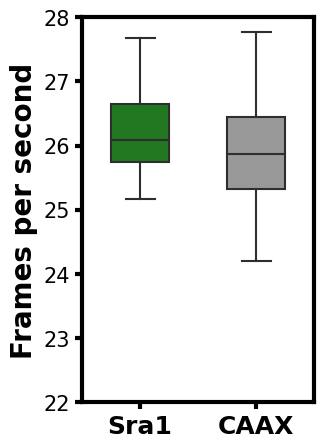

In [11]:
_,ax = plt.subplots(figsize = (3,5))
sns.boxplot(fps,width = 0.5,palette = ['#138613','#999999'])
plt.ylabel('Frames per second',size = 20,fontweight='bold')
plt.xticks(fontsize = 18)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.yticks(fontsize = 15)
# increase tick width
ax.tick_params(width=3,size = 5)
plt.xticks(weight = 'bold')
plt.ylim(22,28)
plt.savefig(PATH + "FigS2D_fps.png",dpi = 300,bbox_inches = 'tight')

# Plot tracks

In [12]:
image = io.imread(PATH + 'Controls/example_images/240117_Halo-caax_10nM_JF646_p8_15ms_26_MMStack_Default.ome.tif')

In [13]:
image.shape

(161, 157)

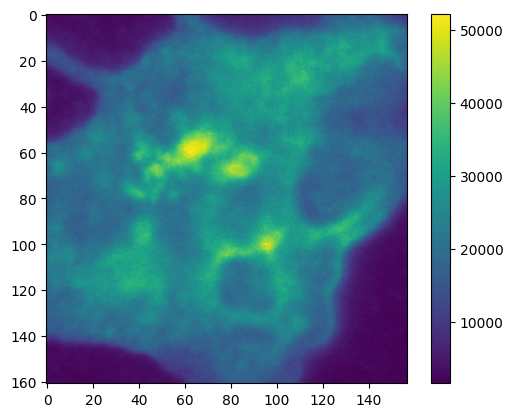

In [14]:
plt.imshow(image)
plt.colorbar()

In [15]:
track= pd.read_csv(PATH + 'Controls/CAAX_tracks_example.csv',index_col=1,skiprows=[0,1,3])

In [16]:
example = track

In [17]:
rois_n = [382,278,376,316,714]

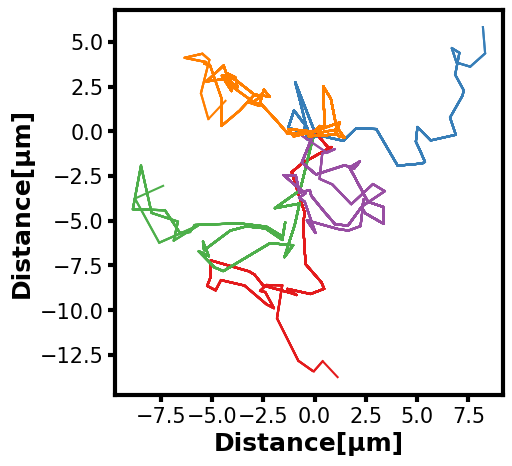

In [18]:
fig,ax = plt.subplots(figsize=(5,5))  
p = 0
for n in rois_n:
    roi = example[example['Track ID'] == n].sort_values('Frame')
    roi.X = roi.X-roi.iloc[0,3]
    roi.Y = roi.Y-roi.iloc[0,4]
    x_zip = []
    y_zip = []
    accent = cm.get_cmap('Accent')
    for i in roi.Frame:
        x = roi[roi.Frame == i].iloc[0,3]
        y = roi[roi.Frame == i].iloc[0,4]
        ax.plot(x_zip,y_zip,linestyle = '-',c = plt.cm.Set1(p),lw = 1.5)
        x_zip.append(x)
        y_zip.append(y)
    p+=1
plt.xlabel('Distance[µm]',fontsize = 18,fontweight='bold')
plt.ylabel('Distance[µm]',fontsize = 18,fontweight='bold')
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig(PATH + 'Fig3G_CAAX_tracks_examples.png',dpi = 300, bbox_inches = 'tight')

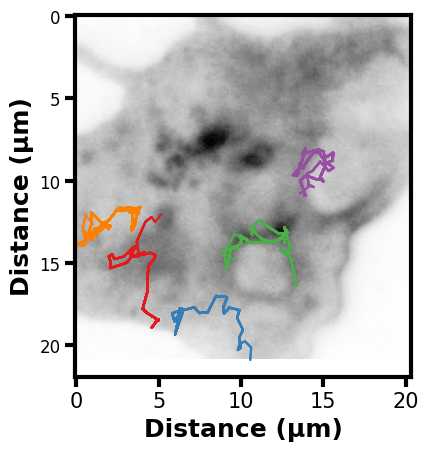

In [19]:
fig,ax = plt.subplots(figsize=(5,4.7))  
im = plt.imshow(image,cmap = 'Greys',vmax = 52000)
p = 0
for n in rois_n:
    roi = example[example['Track ID'] == n].sort_values('Frame')
    roi.X = roi.X/0.26
    roi.Y = roi.Y/0.26
    x_zip = []
    y_zip = []
    accent = cm.get_cmap('Accent')
    for i in roi.Frame:
        x = roi[roi.Frame == i].iloc[0,3]
        y = roi[roi.Frame == i].iloc[0,4]
        ax.plot(x_zip,y_zip,linestyle = '-',c = plt.cm.Set1(p),lw = 1.5)
        x_zip.append(x)
        y_zip.append(y)
    p+=1
plt.xlabel('Distance (µm)',fontsize = 18,fontweight='bold')
plt.ylabel('Distance (µm)',fontsize = 18,fontweight='bold')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 7)
plt.xticks(ticks = [0,38.5,77,115.5,154],labels = [0,5,10,15,20],size = 15)
plt.yticks(ticks = [0,38.5,77,115.5,154],labels = [0,5,10,15,20],size = 15)
plt.yticks(size = 12)
plt.savefig(PATH + 'FigS2C_CAAX_tracks_imposed.png',dpi = 300, bbox_inches = 'tight')

In [20]:
image = io.imread(PATH + 'halo-sra1/example_images/240117_Halo-sra1_10nM_JF646_p8_15ms_9_MMStack_Default.ome.tif kept stack.tif')

In [21]:
track= pd.read_csv(PATH + 'halo-sra1/Sra1_tracks_example.csv',index_col=1,skiprows=[0,1,3])

In [22]:
rois_n = [161,169,33,194,24]

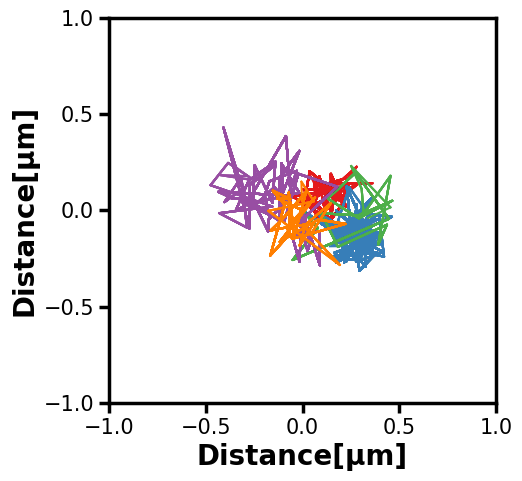

In [23]:
fig,ax = plt.subplots(figsize=(5,5))  
p = 0
for n in rois_n:
    roi = track[track['Track ID'] == n].sort_values('Frame')
    roi.X = roi.X-roi.iloc[0,3]
    roi.Y = roi.Y-roi.iloc[0,4]
    x_zip = []
    y_zip = []
    accent = cm.get_cmap('Accent')
    for i in roi.Frame:
        x = roi[roi.Frame == i].iloc[0,3]
        y = roi[roi.Frame == i].iloc[0,4]
        ax.plot(x_zip,y_zip,linestyle = '-',c = plt.cm.Set1(p),lw = 1.5)
        x_zip.append(x)
        y_zip.append(y)
    p+=1
plt.xlabel('Distance[µm]',fontsize = 20,fontweight='bold')
plt.ylabel('Distance[µm]',fontsize = 20,fontweight='bold')
plt.xticks(ticks = [-1,-0.5,0,0.5,1],size = 15)
plt.yticks(ticks = [-1,-0.5,0,0.5,1],size = 15)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)

# increase tick width
ax.tick_params(width=2.5,size= 7)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.savefig(PATH + 'Fig3F_Sra1_tracks_example.png',dpi = 300, bbox_inches = 'tight')

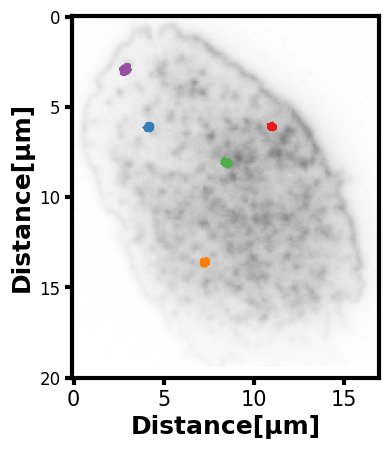

In [25]:
fig,ax = plt.subplots(figsize=(5,4.7))  
im = plt.imshow(image,cmap = 'Greys',vmax = 52000)
p = 0
for n in rois_n:
    roi = track[track['Track ID'] == n].sort_values('Frame')
    roi.X = roi.X/0.26
    roi.Y = roi.Y/0.26
    x_zip = []
    y_zip = []
    accent = cm.get_cmap('Accent')
    for i in roi.Frame:
        x = roi[roi.Frame == i].iloc[0,3]
        y = roi[roi.Frame == i].iloc[0,4]
        ax.plot(x_zip,y_zip,linestyle = '-',c = plt.cm.Set1(p),lw = 4)
        x_zip.append(x)
        y_zip.append(y)
    p+=1
plt.xlabel('Distance[µm]',fontsize = 18,fontweight='bold')
plt.ylabel('Distance[µm]',fontsize = 18,fontweight='bold')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.xticks(ticks = [0,38.5,77,115.5],labels = [0,5,10,15],size = 15)
plt.yticks(ticks = [0,38.5,77,115.5,154],labels = [0,5,10,15,20],size = 15)
plt.yticks(size = 12)
plt.savefig(PATH + 'FigS3B_tracks_examples_imposed.png',dpi = 300, bbox_inches = 'tight')

# Plot kymographs

In [26]:
image = io.imread(PATH + 'Controls/Images_for_kymo/kymo_1.tif')

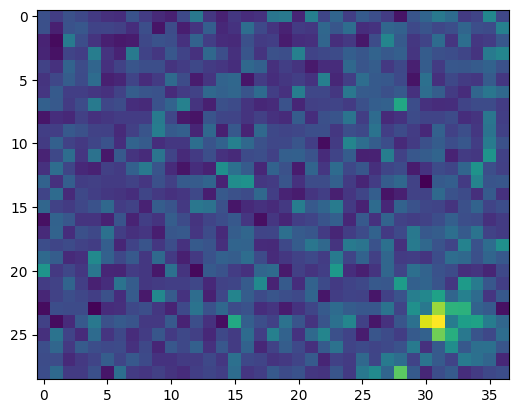

In [27]:
plt.imshow(image[0])

In [28]:
# Projection on the x axis
kymograph = []
for i in range(len(image)):
    kymograph.append(np.sum(image[i], axis = 0))

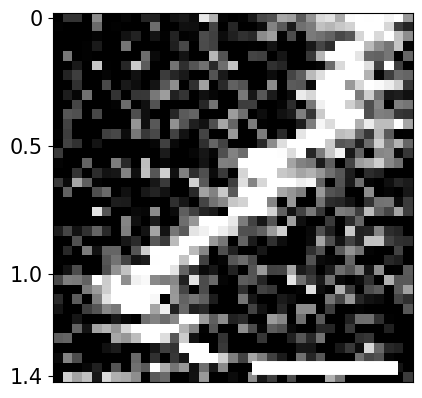

In [29]:
# plt.figure(figsize = (3,8))
plt.imshow(kymograph,vmin = 15100,vmax= 15800, cmap='Greys_r')
# plt.axis('off')
for i in range(36,37):
    plt.hlines(i,20,35,colors='white',lw = 10)
plt.yticks(ticks = [0,13.15,26.31,36.84],labels=[0,0.5,1.0,1.4],size = 15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.savefig(PATH + 'Fig3G_CAAX_kymo_1.png',dpi = 300,bbox_inches = 'tight')

In [30]:
image = io.imread(PATH + 'Controls/Images_for_kymo/kymo_2.tif')

In [31]:
# Projection on the x axis
kymograph = []
for i in range(len(image)):
    kymograph.append(np.sum(image[i], axis = 0))

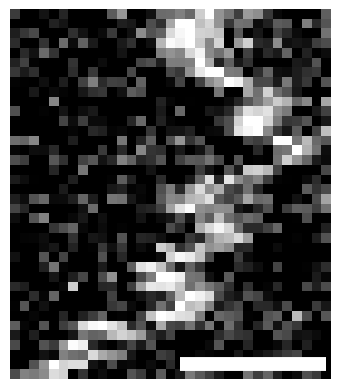

In [32]:
plt.imshow(kymograph,vmin = 18800,vmax= 19700, cmap='Greys_r')
plt.axis('off')
plt.yticks(ticks = [0,13.15,26.31,36.84],labels=[0,0.5,1,1.4])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
for i in range(36,37):
    plt.hlines(i,17,32,colors='white',lw = 10)
plt.savefig(PATH + 'Fig3G_CAAX_kymo_2.png',dpi = 300,bbox_inches = 'tight')

In [33]:
image = io.imread(PATH + 'halo-sra1/Images_for_kymo/kymo-1.tif')

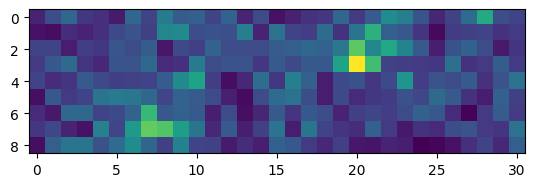

In [34]:
plt.imshow(image[0])

In [35]:
# Projection on the x axis
kymograph = []
for i in range(len(image)):
    kymograph.append(np.sum(image[i], axis = 0))

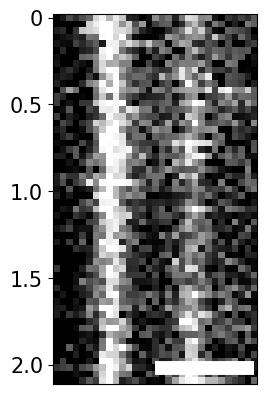

In [36]:
plt.imshow(kymograph, vmin = 4750,vmax = 5450,cmap='Greys_r')
# plt.axis('off')
plt.yticks(ticks = [0,13.15,26.31,39.47,52.63],labels=[0,0.5,1.0,1.5,2.0],size = 15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
for i in range(53,54):
    plt.hlines(i,15,30,colors='white',lw = 10)
plt.savefig(PATH + 'Fig3F_Sra1_kymo_1.png',dpi = 300,bbox_inches = 'tight')

In [37]:
image = io.imread(PATH + 'halo-sra1/Images_for_kymo/kymo-2.tif')

In [38]:
# Projection on the x axis
kymograph = []
for i in range(len(image)):
    kymograph.append(np.sum(image[i], axis = 0))

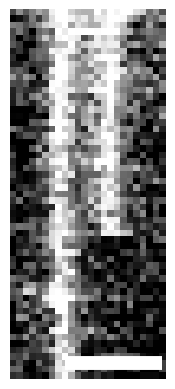

In [39]:
plt.imshow(kymograph[0:60],vmin = 6800,vmax = 7600,cmap='Greys_r')
plt.axis('off')
for i in range(54,55):
    plt.hlines(i,8,23,colors='white',lw = 10)
# plt.colorbar()
# plt.xticks(size = 15)
# plt.yticks(size = 15)
plt.savefig(PATH + 'Fig3F_Sra1_kymo_2.png',dpi = 300,bbox_inches = 'tight')